In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import sklearn as sk

2024-05-19 10:23:52.647440: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 10:23:52.650957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 10:23:52.686535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 10:23:53.511938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the binary file
binary_file = 'games.npz'
data = np.load(binary_file, allow_pickle=True)

images = data['images']
images.astype('float32')
labels = data['labels']
label_names = data['label_names']


df = pd.DataFrame({
    'image': list(images),
    'label': labels
})
df['label'] = labels

In [3]:
df.loc[:, "image"].shape

(84447,)

In [4]:
df["image"].shape

(84447,)

In [5]:
df.head()

,image,label
0,"[[[0.7764706, 0.8627451, 0.93333334], [0.78039...",0
1,"[[[0.5686275, 0.54509807, 0.5176471], [0.56862...",0
2,"[[[0.47058824, 0.43529412, 0.38039216], [0.474...",0
3,"[[[0.2901961, 0.4392157, 0.5764706], [0.356862...",0
4,"[[[0.48235294, 0.5294118, 0.5764706], [0.49411...",0


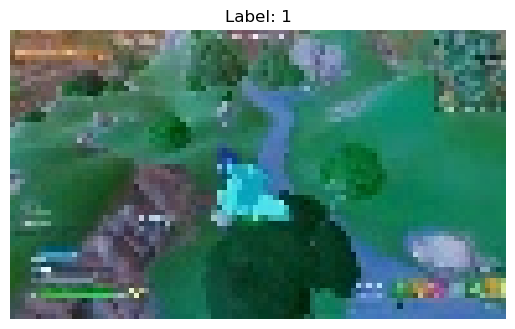

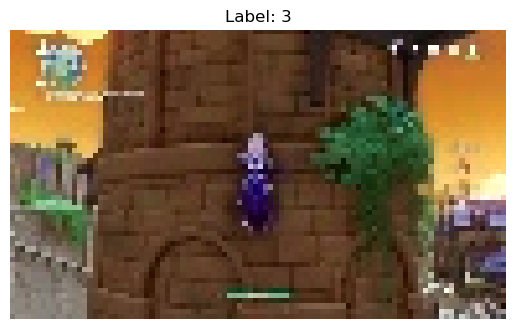

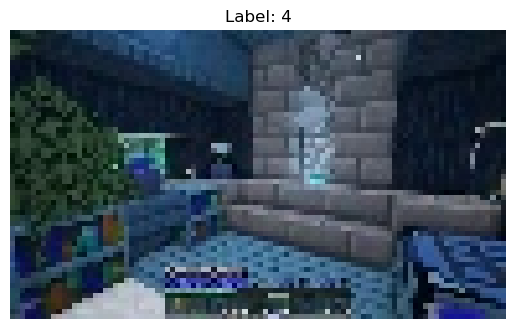

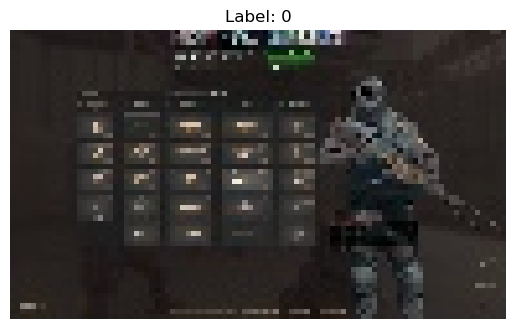

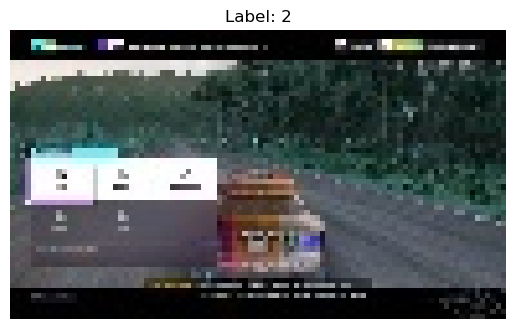

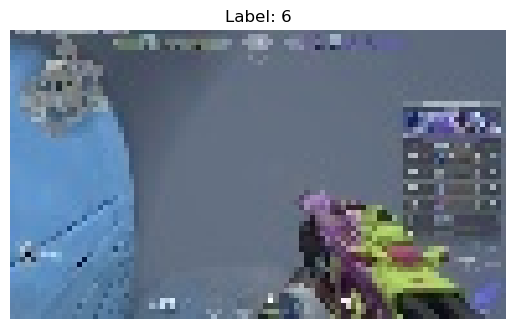

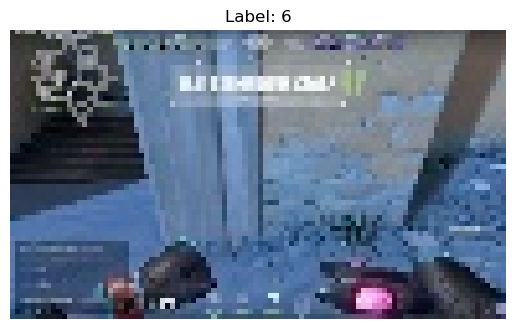

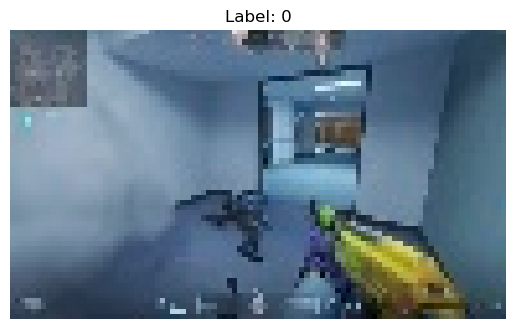

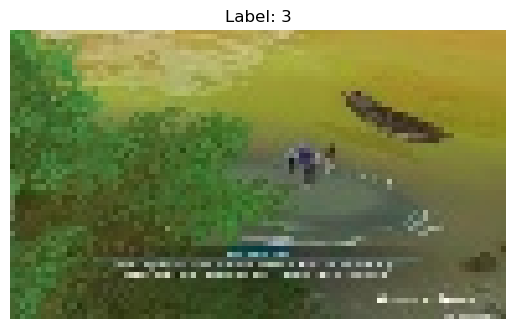

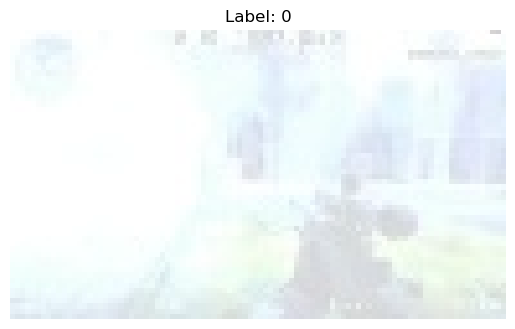

In [6]:
import matplotlib.pyplot as plt


df = df.sample(frac=1).reset_index(drop=True)

for elt in range(10):
    # Display the first image
    first_image = df['image'].iloc[elt]
    first_label = df['label'].iloc[elt]

    plt.imshow(first_image)
    plt.title(f'Label: {first_label}')
    plt.axis('off')  # Hide the axis
    plt.show()

In [7]:
# Function to sample 10,000 instances of each label
def sample_labels(df, label_column, sample_size=10000):
    # Group by label and sample from each group
    sampled_df = df.groupby(label_column).apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    return sampled_df

# Apply the function to get 10,000 samples of each label
sampled_df = sample_labels(df, 'label', 1000)

# Verify the result
print(sampled_df['label'].value_counts())

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
Name: count, dtype: int64


In [9]:
# Convert DataFrame to numpy arrays
images = np.array(sampled_df['image'].tolist()).reshape(7000, 56, 96, 3)
labels = np.array(sampled_df['label'].tolist())

# Split the data into training and testing sets
#x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
#images = np.array(images)

In [10]:
images.shape

(7000, 56, 96, 3)

In [11]:
split_part = 0.2
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True)

print(x_train.shape)
print(y_train.shape)


(5600, 56, 96, 3)
(5600,)


In [12]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test) 

In [13]:
x_train.shape

(5600, 56, 96, 3)

In [14]:
x_train[0].shape

(56, 96, 3)

In [20]:
def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size: size of each processed batch
    :param int epochs: number of epochs
    """
    callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
    model.fit(x, y, epochs=10, batch_size=64, callbacks=[callback], validation_data=(x_test, y_test))

In [21]:
def cnn_model(input_shape: tuple, num_classes: int):
    """
    Returns a compiled keras Conv2D model
 This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.   
    :param tuple input_shape: shape of ONE example as passed to the first layer
    :param int num_classes: number of output classes as passed to the last layer
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=[56, 96, 3]))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(7, activation='softmax'))
              
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=tf.keras.optimizers.SGD(),
        metrics=['accuracy']
    )
    return model

In [22]:
model = cnn_model(x_train.shape[1:], 10)


In [23]:
x_train.shape

(5600, 56, 96, 3)

In [24]:
train_model(model, x_train, y_train, x_test, y_test)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 47s 524ms/step - accuracy: 0.6644 - loss: 1.0386 - val_accuracy: 0.1536 - val_loss: 2.1237
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 518ms/step - accuracy: 0.9473 - loss: 0.1819 - val_accuracy: 0.1536 - val_loss: 2.3468
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 525ms/step - accuracy: 0.9695 - loss: 0.1090 - val_accuracy: 0.2650 - val_loss: 2.0391
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 523ms/step - accuracy: 0.9817 - loss: 0.0615 - val_accuracy: 0.3757 - val_loss: 1.6282
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 523ms/step - accuracy: 0.9860 - loss: 0.0505 - val_accuracy: 0.6821 - val_loss: 0.8406
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 521ms/step - accuracy: 0.9937 - loss: 0.0348 - val_accuracy: 0.8900 - val_loss: 0.3701
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 523ms/step - accuracy: 0.9943 - loss: 0.0259 - val_accuracy: 0.9521 - val_loss: 0.2059
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 524ms/step - accuracy: 0.9949 - loss: 0.0246 - val_accu